In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from comet_ml import Experiment
import time
import os
import pickle
import configparser
np.random.seed(42)
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

seed=42

In [2]:
config = configparser.ConfigParser()
config.read('../configfile.ini')
type_env = "comet_ml_dev" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_best_shot']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="Best Shot Models")
comet_exp_obj.log_notebook("11_best_shot_all.ipynb")

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/amandalmia/bestshot-models/7e1d73b642864f7d98dd487536d70906



Using cpu device


In [3]:
def load_datafile():
    """
    This function used to load the datafiles and preprocess using mix max scaling technique. 
    It also takes only relevant columns which was found during advanced feature engineering.  
    Returns: x_train, y_train, x_val, y_val 4 dataframes of training and validation set respectively. 
    """
    x_train = pd.read_pickle("../data/trainvaldata/x_train.pkl")
    x_val = pd.read_pickle("../data/trainvaldata/x_val.pkl")
    y_train = pd.read_pickle("../data/trainvaldata/y_train.pkl")
    y_val = pd.read_pickle("../data/trainvaldata/y_val.pkl")
    
    

    comet_exp_obj.log_dataframe_profile(x_train, "x_train")
    comet_exp_obj.log_dataframe_profile(y_train, "y_train")
    comet_exp_obj.log_dataframe_profile(x_val, "x_val")
    comet_exp_obj.log_dataframe_profile(y_val, "y_val")
    
    x_train = x_train[['angle', 'distance_from_last_event', 'empty_net', 'shot_type_Wrap-around', 'y_coordinate', 'speed', 'distance', 'x_coordinate', 'game_period', 'shot_type_Tip-In', 'shot_type_Wrist Shot', 'game_seconds']]
    x_val = x_val[['angle', 'distance_from_last_event', 'empty_net', 'shot_type_Wrap-around', 'y_coordinate', 'speed', 'distance', 'x_coordinate', 'game_period', 'shot_type_Tip-In', 'shot_type_Wrist Shot', 'game_seconds']]
    y_val = y_val.values
    
    x_train=(x_train-x_train.mean())/x_train.std()
    x_val=(x_val-x_val.mean())/x_val.std()

    return x_train, y_train, x_val, y_val


def transform_data_for_nn(x_train, x_val, y_train, y_val):
    """
    This functions transform the data which is required to ingest in neural network. The code is written in 
    PyTorch hence it needs to convert into datasets and dataloaders in respective format.
    Input:  x_train, y_train, x_val, y_val 4 dataframes of training and validation set respectively. 
    Returns: Dataloaders of training and validation sets of data. 
    """
    train_data = data_utils.TensorDataset(torch.Tensor(x_train.values.astype(np.float32)), 
                                      torch.LongTensor(y_train.values.astype(np.float32)))
    val_data = data_utils.TensorDataset(torch.Tensor(x_val.values.astype(np.float32)), 
                                        torch.LongTensor(y_val.astype(np.float32)))


    batch_size = 64

    # Create data loaders.
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    
    return train_dataloader, val_dataloader
    

In [4]:

x_train, y_train, x_val, y_val = load_datafile()

# Data Prep for Neural Network
num_classes = 2
class_sample_counts = [(y_train == 0).sum()/len(y_train), (y_train == 1).sum()/len(y_train)]
class_weights = 1./torch.Tensor(class_sample_counts)
train_dataloader, val_dataloader = transform_data_for_nn(x_train, x_val, y_train, y_val)

data_dict = {
    "Neural_Network" : (train_dataloader, val_dataloader),
    "kNN" : (x_train, y_train, x_val, y_val),
    "Random_Forest" : (x_train, y_train, x_val, y_val),
    "Decision_Tree" : (x_train, y_train, x_val, y_val)
}



COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring


# Neural Network Model

In [5]:
### Neural Network Model 

class NeuralNets(nn.Module):
    """
    A custom Neural Network Class developed on PyTorch framework             
    """
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.Softmax()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

def train(dataloader, model, loss_func, optimizer):
    """
    This functions train a neural network for learining the algorithm based on the given features. 
    Input: Dataloader, model which we defined, a loss function which we took as CrossEntropy and an AdamW as 
    an optimizer. 
    Returns: trained model
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return model

def predfit(dataloader, model, loss_fn, log_exp):
    """
    Once the model is trained, we try to predict on the test / validation data. 
    Inputs:  Dataloader, model which we trained previously, a loss function which we took as CrossEntropy 
    and an AdamW as an optimizer.
    Return: None
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    pred_list = np.empty((0,2), float)
    true_y = np.empty((0), int)
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            pred_list = np.append(pred_list, pred.numpy(), axis=0)
            true_y = np.append(true_y, y.numpy(), axis=0)
            
    y_val = true_y      
    pred_list = np.argmax(pred_list, axis=1)
    
    test_loss /= num_batches
    correct /= size
    class_report = classification_report(y_val, pred_list, output_dict=True)
    report_dict = {}
    for k, v in class_report.items():
        if type(v) is dict:
            for vk, val in v.items():
                report_dict[k + "_" + vk] = round(val, 3)
    print(classification_report(y_val, pred_list))
    print(confusion_matrix(y_val, pred_list))
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, pred_list)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    print(f"roc_auc: {roc_auc}")
    if log_exp:
        metrics = {"accuracy":(100*correct), "test_loss": test_loss, "roc_auc" : roc_auc}
        for k, v in report_dict.items():
            metrics[k] = v
        comet_exp_obj.log_metrics(metrics)
        comet_exp_obj.log_confusion_matrix(y_true=y_val, y_predicted=pred_list, title="Confusion Matrix", 
                                           file_name="Confusion Matrix for Neural Network")




# kNN Model

In [6]:
### kNN Model 

def knn(x_train,y_train,x_test,y_test):
    """
    We defined a new model kNN model 
    """
    # initialize the values of k for our k-Nearest Neighbor classifier along with the
    # list of accuracies for each value of k
    kVals = range(40, 50, 2)
    accuracies = []
    
    # loop over various values of `k` for the k-Nearest Neighbor classifier
    for k in range(40, 50, 2):
        # train the k-Nearest Neighbor classifier with the current value of `k`
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train, y_train)
    
        # evaluate the model and update the accuracies list
        score = model.score(x_test, y_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(model.predict(x_test),y_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)    
        print(f"roc_auc: {roc_auc}")
        print("k=%d, accuracy=%.2f%%" % (k, score * 100))
        accuracies.append(score)
    
    # find the value of k that has the largest accuracy
    i = int(np.argmax(accuracies))
    print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i],accuracies[i] * 100))
    # re-train our classifier using the best k value and predict the labels of the
    # test data
    start = time.time()
    model = KNeighborsClassifier(n_neighbors=kVals[i])
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    
    # show a final classification report demonstrating the accuracy of the classifier
    print("EVALUATION ON TESTING DATA")
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    end = time.time()
    print("time :",(end-start)/60)
    
    accuracy = np.mean(y_test == predictions) * 100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)    

    metrics = {"accuracy": accuracy, "roc_auc" : roc_auc}
    comet_exp_obj.log_metrics(metrics)
    comet_exp_obj.log_confusion_matrix(y_true=y_test, y_predicted=predictions, title="Confusion Matrix", 
                                       file_name="Confusion Matrix for kNN")
        
    return model



# Random Forest

In [7]:
### Random Forest Model 


def random_forest(variables_train,labels_train,variables_test,labels_test):       
    rf_classifier=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                         max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                                         bootstrap=True, oob_score=False, n_jobs=None, random_state=0, 
                                         verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    rf_classifier=rf_classifier.fit(variables_train,labels_train)
    
    rf_predictions=rf_classifier.predict(variables_test)

    accuracy = np.mean(labels_test == rf_predictions) * 100
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, rf_predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    metrics = {"accuracy" : accuracy, "roc_auc" : roc_auc}
    
    comet_exp_obj.log_metrics(metrics)
    comet_exp_obj.log_confusion_matrix(y_true=labels_test, y_predicted=rf_predictions, title="Confusion Matrix", 
                                       file_name="Confusion Matrix for Random Forest")
    return rf_classifier
      



# Decison Tree

In [8]:
# Decison Tree Model

def get_best_params(x_train, y_train):
    
    dt_obj = DecisionTreeClassifier()
    # https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
    param_grid = {
        "splitter" : ['best', 'random'],
        "max_depth" : list(range(2, 50)),
        "min_samples_split" : np.linspace(0.1, 1.0, 10, endpoint=True),
        "min_samples_leaf" : np.linspace(0.1, 0.5, 5, endpoint=True),
        "max_features" : list(range(1, x_train.shape[1])),
        "max_leaf_nodes" : list(range(2, 10))
    }
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    clf = RandomizedSearchCV(dt_obj, param_grid, random_state=seed, verbose=3, cv=cv, scoring="accuracy",  
                             n_jobs=-1)

    model = clf.fit(x_train, y_train)
    return model.best_params_

def predict(best_parameters, x_train, y_train, x_val, y_val):
    best_params = best_parameters
    dt_obj = DecisionTreeClassifier(splitter=best_params["splitter"], max_depth=best_params["max_depth"], 
                                    min_samples_split=best_params["min_samples_split"], 
                                    min_samples_leaf=best_params["min_samples_leaf"],
                                    max_features=best_params["max_features"], 
                                    max_leaf_nodes=best_params["max_leaf_nodes"])
    model = dt_obj.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    
    accuracy = np.mean(y_val == y_pred) * 100
    print("Accuracy: %.2f%%" % (accuracy * 100.0))  

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    print(f"roc_auc: {roc_auc}")
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    metrics = {"accuracy" : accuracy, "roc_auc" : roc_auc}
    comet_exp_obj.log_metrics(metrics)
    comet_exp_obj.log_confusion_matrix(y_true=y_val, y_predicted=y_pred, title="Confusion Matrix", 
                                       file_name="Confusion Matrix for Random Forest")
    return model
    

In [9]:
def build_log_reg_model(model, x_val, y_val, no_of_features, k):
    if no_of_features == 1:
        x_val = x_val.values.reshape(-1, 1)
        
    y_pred = model.predict(x_val)
    accuracy = np.mean(y_val == y_pred) * 100
    print("correctly predicted / total is ", accuracy)
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    metrics = {k + "_feature_accuracy":accuracy}
    classNames = np.unique(y_val)

    comet_exp_obj.log_metrics(metrics)
    comet_exp_obj.log_confusion_matrix(y_true=y_val, y_predicted=y_pred, title="Confusion Matrix for " + k,
                                      file_name="Confusion Matrix for " + k)

for k, v in data_dict.items():
    print("Training and Predition operations for ", k)
    if k == "Neural_Network":
        model = NeuralNets().to(device)
        
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
        
        train_dataloader, val_dataloader = data_dict[k]
        epochs = 10
        log_comet = False
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            trained_model = train(train_dataloader, model, loss_fn, optimizer)
            predfit(val_dataloader, trained_model, loss_fn, log_exp=log_comet)
        print("Done!")
        
        filename = '../model/' + k + "_Model.pth"
        torch.save(model.state_dict(), filename)
        print("Saved PyTorch Model State to model.pth")
        
        comet_exp_obj.log_model(k + "_Model", file_or_folder=filename, overwrite=True, 
                                file_name=k + "_Model")
        log_comet = True
        predfit(val_dataloader, model, loss_fn, log_exp=log_comet)
    
    
    elif k == "kNN":
        x_train, y_train, x_val, y_val = data_dict[k]
        trained_model = knn(x_train, y_train, x_val, y_val)
        
        filename = '../model/' + k + "_Model.pkl"
        pickle.dump(trained_model, open(filename, 'wb'))
        comet_exp_obj.log_model(k + "_Model", file_or_folder=filename, overwrite=True, file_name=k + "_Model")
        
    elif k == "Random_Forest":
        x_train, y_train, x_val, y_val = data_dict[k]
        trained_model = random_forest(variables_train=x_train, labels_train=y_train, variables_test=x_val, 
                                      labels_test=y_val)
        filename = '../model/' + k + "_Model.pkl"
        pickle.dump(trained_model, open(filename, 'wb'))
        comet_exp_obj.log_model(k + "_Model", file_or_folder=filename, overwrite=True, file_name=k + "_Model")
        
    elif k == "Decision_Tree":
        x_train, y_train, x_val, y_val = data_dict[k]
        best_params_ = get_best_params(x_train, y_train)
        trained_model = predict(best_params_, x_train, y_train, x_val, y_val)
        
        filename = '../model/' + k + "_Model.pkl"
        pickle.dump(trained_model, open(filename, 'wb'))
        comet_exp_obj.log_model(k + "_Model", file_or_folder=filename, overwrite=True, file_name=k + "_Model")
    else:
        pass

Training and Predition operations for  Neural_Network
Epoch 1
-------------------------------
loss: 0.690617  [    0/252580]
loss: 0.687519  [64000/252580]
loss: 0.692538  [128000/252580]
loss: 0.675122  [192000/252580]
              precision    recall  f1-score   support

           0       0.93      0.54      0.68     57445
           1       0.12      0.62      0.20      5700

    accuracy                           0.55     63145
   macro avg       0.53      0.58      0.44     63145
weighted avg       0.86      0.55      0.64     63145

[[30912 26533]
 [ 2184  3516]]
Test Error: 
 Accuracy: 54.5%, Avg loss: 0.685955 

roc_auc: 0.5774784118447394
Epoch 2
-------------------------------
loss: 0.694427  [    0/252580]
loss: 0.668631  [64000/252580]
loss: 0.692534  [128000/252580]
loss: 0.648168  [192000/252580]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     57445
           1       0.16      0.42      0.23      5700

    accuracy

In [10]:
def get_probs_nn(model, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    pred_list = np.empty((0,2), float)
    true_y = np.empty((0), int)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_list = np.append(pred_list, pred.numpy(), axis=0)
            true_y = np.append(true_y, y.numpy(), axis=0)

    y_val = true_y
    testy = y_val
    ns_probs = [0 for _ in range(len(testy))]
    return pred_list, testy, ns_probs

AUC ROC Scores for BaseLine Model for features -  Neural_Network
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.722
AUC ROC Scores for BaseLine Model for features -  kNN
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.711
AUC ROC Scores for BaseLine Model for features -  Random_Forest
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.727
AUC ROC Scores for BaseLine Model for features -  Decision_Tree
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.639


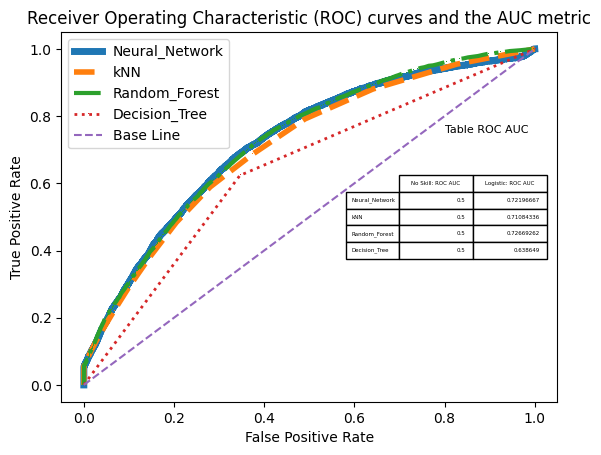

In [11]:
def create_roc_auc_curve(dataloader, x_val, y_val, k): 
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../model/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass

    predicted_probablities = pred_list 
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = round(roc_auc_score(testy, goal_prob), 8)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, goal_prob)
    
    return ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc
    
    
plt.figure()    
table_values = []
markers_list = [",", ",", ",", ",", "P"]
valdataloader = data_dict["Neural_Network"][1]
x_val = data_dict["kNN"][2]
y_val = data_dict["kNN"][3]

for index, (k, v) in enumerate(data_dict.items()):
#     if k == "Random_Forest":
    lw=5-4*index/len(data_dict)
    ls=['-','--','-.',':'][index%4]
    print("AUC ROC Scores for BaseLine Model for features - ", k)
    ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc = create_roc_auc_curve(valdataloader, x_val, y_val, k)
    table_values.append([ns_auc, lr_auc])
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker=markers_list[index], label=k, linewidth=lw, linestyle=ls)
    
col_labels=['No Skill: ROC AUC','Logistic: ROC AUC']
row_labels=[*data_dict]
table_vals=table_values
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.15]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
plt.text(0.8,0.75,'Table ROC AUC',size=8)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) curves and the AUC metric")
plt.legend()
comet_exp_obj.log_figure(figure_name="Receiver Operating Characteristic (ROC) curves and the AUC metric", 
                             figure=plt, overwrite=False, step=None)
plt.show()


## Question 2
The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data. 

Goal Shot Rate for BaseLine Model for features -  Neural_Network
Goal Shot Rate for BaseLine Model for features -  kNN
Goal Shot Rate for BaseLine Model for features -  Random_Forest
Goal Shot Rate for BaseLine Model for features -  Decision_Tree


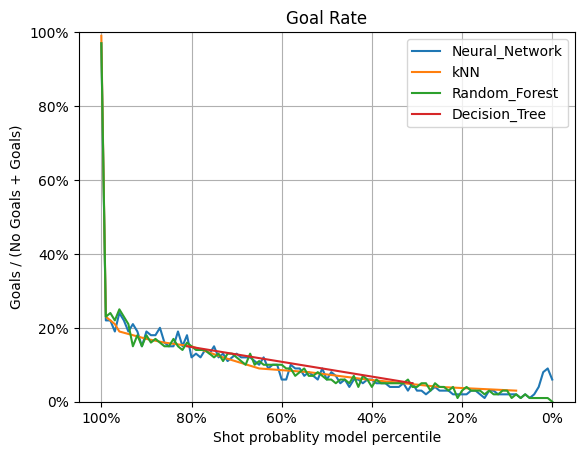

In [12]:
def plot_goal_shot_rate(dataloader, x_val, y_val, k):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../model/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = round((df.groupby(by='percentile_of_goal').sum() / 
                       df.groupby(by='percentile_of_goal').count())*100)
    goal_rate['percentile'] = goal_rate.index

    plt1.plot(goal_rate["percentile"], goal_rate["is_goal"], label=k)


fig, (plt1) = plt.subplots(1, 1)
valdataloader = data_dict["Neural_Network"][1]
x_val = data_dict["kNN"][2]
y_val = data_dict["kNN"][3]

for index, (k, v) in enumerate(data_dict.items()):
    print("Goal Shot Rate for BaseLine Model for features - ", k)
    plot_goal_shot_rate(valdataloader, x_val, y_val, k)

plt1.set_ylim(0,100)
plt1.xaxis.set_major_formatter('{x:1.0f}%')
plt1.yaxis.set_major_formatter('{x:1.0f}%')
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Goals / (No Goals + Goals)')
plt.grid()
plt.title("Goal Rate")
plt.legend()
comet_exp_obj.log_figure(figure_name="Goal Rate", figure=fig,
                   overwrite=False, step=None)
plt.show()




Cumulative Goal for BaseLine Model for features -  Neural_Network
Cumulative Goal for BaseLine Model for features -  kNN
[CV 6/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.2s
[CV 13/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 19/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 24/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 3/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 8/30] END max_depth=18, max_feat

[CV 5/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.3s
[CV 16/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 14/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 27/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 6/30] END max_depth=16, max_features=11, max_leaf_nodes=9, min_samples_leaf=0.2, min_samples_split=0.7000000000000001, splitter=best;, score=0.910 total time=   0.1s
[CV 20/30] END max_depth=16, max_features=11, max_leaf_nodes=9, min_samples_leaf=0.2, min_samples_split=0.7000000000000001, splitter=best;, score=0.910 total time=   0.1s
[C

[CV 2/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.3s
[CV 12/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 18/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 23/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 28/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 4/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 tota

[CV 3/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.3s
[CV 20/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 17/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 21/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 1/30] END max_depth=16, max_features=11, max_leaf_nodes=9, min_samples_leaf=0.2, min_samples_split=0.7000000000000001, splitter=best;, score=0.910 total time=   0.1s
[CV 7/30] END max_depth=16, max_features=11, max_leaf_nodes=9, min_samples_leaf=0.2, min_samples_split=0.7000000000000001, splitter=best;, score=0.910 total time=   0.1s
[CV

[CV 9/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.3s
[CV 27/30] END max_depth=15, max_features=10, max_leaf_nodes=5, min_samples_leaf=0.30000000000000004, min_samples_split=1.0, splitter=best;, score=0.910 total time=   0.1s
[CV 1/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 9/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 15/30] END max_depth=18, max_features=8, max_leaf_nodes=6, min_samples_leaf=0.4, min_samples_split=0.4, splitter=random;, score=0.910 total time=   0.0s
[CV 22/30] END max_depth=16, max_features=11, max_leaf_nodes=9, min_samples_leaf=0.2, min_samples_split=0.7000000000000001, splitter=best;, score=0.910 total time=   0.1s
[CV 28/30] END ma

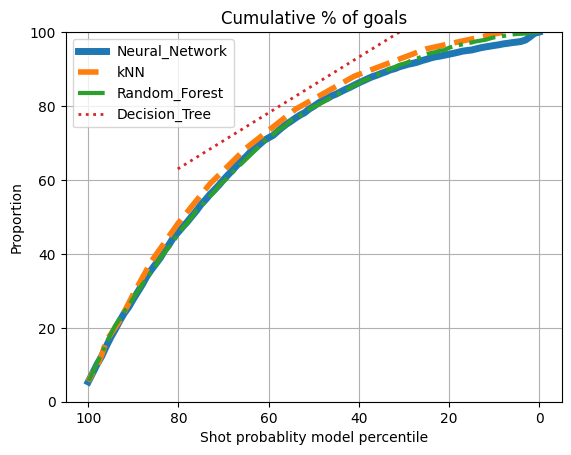

In [13]:
def plot_cumulative_goal(dataloader, x_val, y_val, k, ls, lw):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../model/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list

    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = df.groupby(by='percentile_of_goal').sum()
    goal_rate['percentile'] = goal_rate.index
    
    goal_rate['cum_sum'] = goal_rate.loc[::-1, 'is_goal'].cumsum()[::-1]
    goal_rate['cum_perc'] = 100*goal_rate['cum_sum'] / goal_rate['is_goal'].sum()
    
    plt1.plot(goal_rate["percentile"], goal_rate["cum_perc"], label=k, linewidth=lw, linestyle=ls)

    
graph, (plt1) = plt.subplots(1, 1)
valdataloader = data_dict["Neural_Network"][1]
x_val = data_dict["kNN"][2]
y_val = data_dict["kNN"][3]

for index, (k, v) in enumerate(data_dict.items()):
    print("Cumulative Goal for BaseLine Model for features - ", k)
    lw=5-4*index/len(data_dict)
    ls=['-','--','-.',':'][index%4]
    plot_cumulative_goal(valdataloader, x_val, y_val, k, ls, lw)
        

plt1.set_ylim(0,100)
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Proportion')
plt.grid()
plt.title("Cumulative % of goals")
plt.legend()
comet_exp_obj.log_figure(figure_name="Cumulative % of goals", figure=plt,
                   overwrite=False, step=None)
    
plt.show()

Estimator Plot for BaseLine Model for features -  Neural_Network
Estimator Plot for BaseLine Model for features -  kNN
Estimator Plot for BaseLine Model for features -  Random_Forest
Estimator Plot for BaseLine Model for features -  Decision_Tree


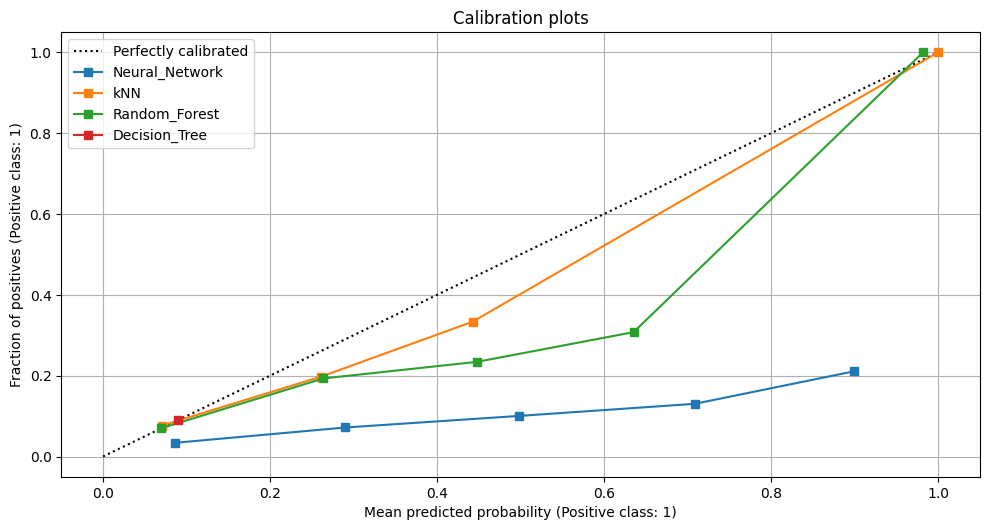

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/amandalmia/bestshot-models/7e1d73b642864f7d98dd487536d70906
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     0_f1-score             : 0.79
COMET INFO:     0_precision            : 0.953
COMET INFO:     0_recall               : 0.674
COMET INFO:     0_support              : 57445
COMET INFO:     1_f1-score             : 0.269
COMET INFO:     1_precision            : 0.168
COMET INFO:     1_recall               : 0.665
COMET INFO:     1_support              : 5700
COMET INFO:     accuracy [4]           : (67.31491012748437, 91.45617230184496)
COMET INFO:     macro avg_f1-score     : 0.529
COMET INFO:     macro avg_precision    : 0.561
COMET INFO:     macro avg_recall       : 0.669
COMET INFO:     macro avg_support      : 63145
COMET INFO: 

COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET INFO: All files uploaded, waiting for confirmation they have been all received


In [14]:
def create_estimator_plot(dataloader, x_val, y_val, k):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../model/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        knn_model = pickle.load(open("../model/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    return CalibrationDisplay.from_predictions(y_val, goal_prob, ax=ax_calibration_curve,name=k)
#     return CalibrationDisplay.from_estimator(model, x_val, y_val, ax=ax_calibration_curve, name=k)
    
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

valdataloader = data_dict["Neural_Network"][1]
x_val = data_dict["kNN"][2]
y_val = data_dict["kNN"][3]

for index, (k, v) in enumerate(data_dict.items()):
    print("Estimator Plot for BaseLine Model for features - ", k)
    calibration_displays[k] = create_estimator_plot(valdataloader, x_val, y_val, k)
                
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
plt.tight_layout()
plt.legend(loc='upper left')

comet_exp_obj.log_figure(figure_name="Calibration Display", figure=plt,
                   overwrite=False, step=None)
plt.show()

comet_exp_obj.end()


    